In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from IPython.display import Image, display
import matplotlib.cm as cm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# Process and Train and Predict

<function matplotlib.pyplot.show(close=None, block=None)>

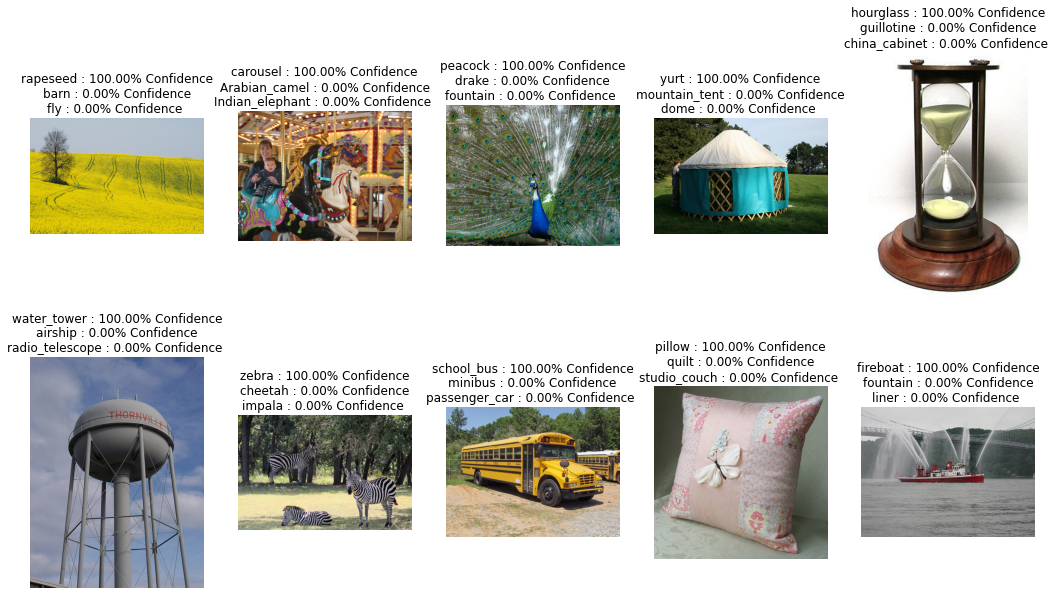

In [2]:
files = ['1.png', '10.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png']
plt.figure(figsize=(18,10))
rows, cols = 2, 5

processed_img_list = []
class_label_list = []
for i in range(10):
    plt.subplot(rows, cols, i+1)
    plt.title(f'Image {files[i]}')
    plt.axis('off')
    plt.imshow(mpimg.imread(files[i]))
    
    
    ## Preprocess image
    img_path = files[i]
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    processed_img_list.append(x)
    
    
    ## Prediction of Image        
    model_ResNet50 = ResNet50(weights='imagenet', include_top=True)
    preds = model_ResNet50.predict(x)
    
    a, b, c = decode_predictions(preds, top=3)[0]
    plt.title('{} : {:.2f}% Confidence\n{} : {:.2f}% Confidence\n{} : {:.2f}% Confidence '.format(a[1], a[2]*100,
                                                                                          b[1], b[2]*100,
                                                                                          c[1], c[2]*100))
    class_label_list.append(a[1])

plt.show

# Extract a list of all the labels in the pre-trained model

In [3]:
full_list = decode_predictions(np.expand_dims(np.arange(1000), 0), top=1000)[0]
image_class_index_list = []
for inner_iter in class_label_list:
    for class_iter in full_list:
        if class_iter[1] == inner_iter:
            image_class_index_list.append(class_iter[2])
print(image_class_index_list)

[984, 476, 84, 915, 604, 900, 340, 779, 721, 554]


# Grad-CAM algorithm

#### Grad-CAM Algorithm Reference Link:  __https://keras.io/examples/vision/grad_cam/__

In [4]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [5]:
# Function to superimpose heatmap onto original image
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img=img_path
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path) # <=== save the image into the directory

    # Display Grad CAM
    #display(Image(cam_path)) # <=== Displays the superimpose image on the fly
    return superimposed_img
    

# Grad-CAM visualizes which area on the input image strongly influences the classification of the input image
### Display heatmap, original and superimpose image side by side First Prediction

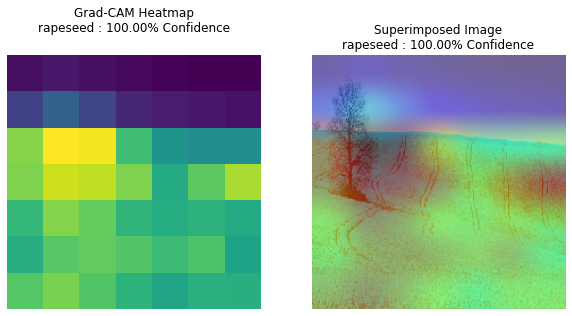

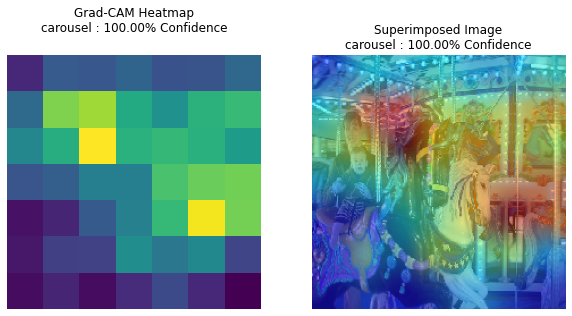

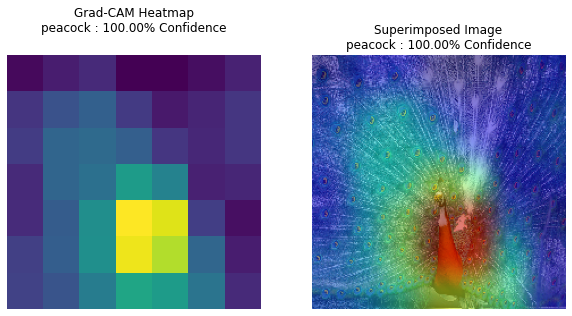

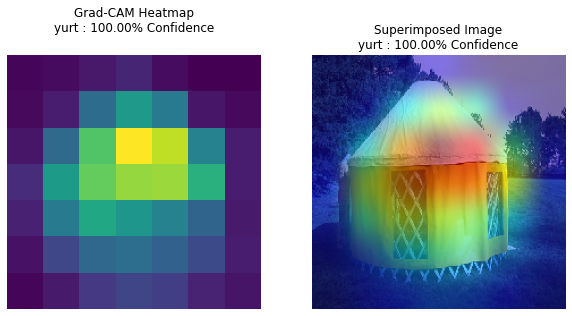

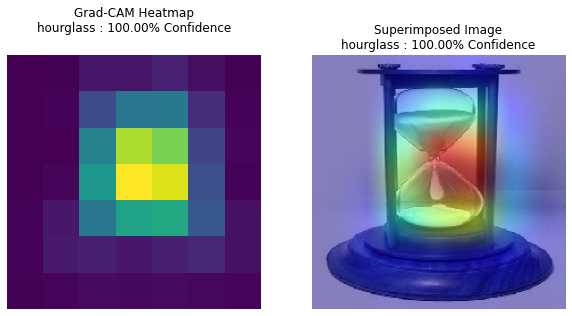

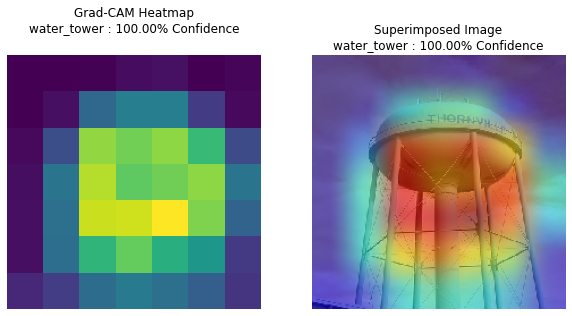

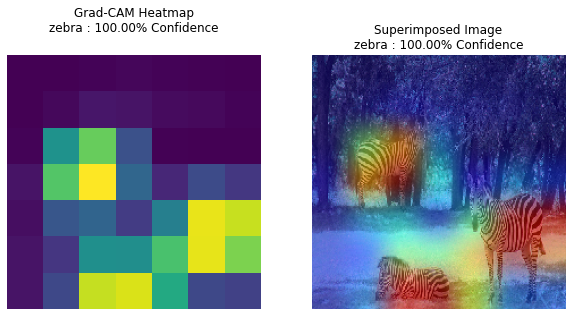

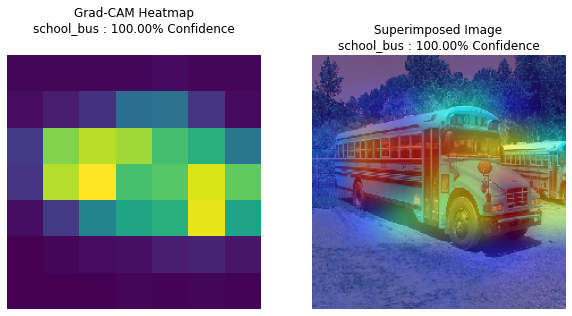

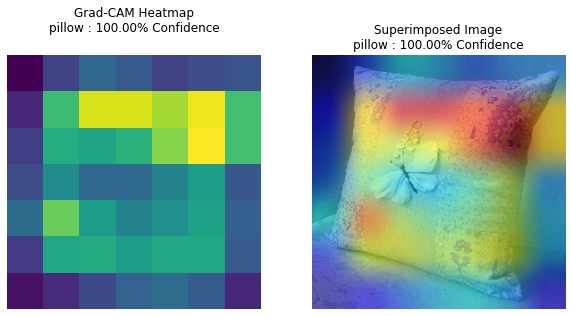

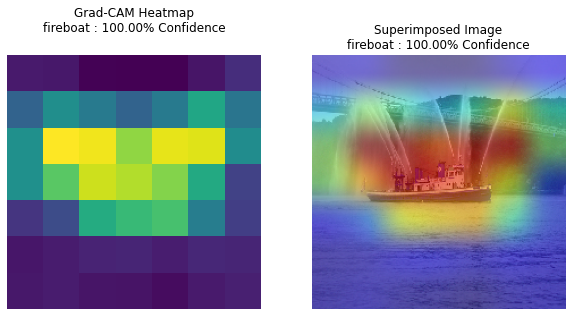

In [6]:
for index in range(0,len(processed_img_list)):
    # iterate over each image
    x = processed_img_list[index]
    image_title = f"{str.split(files[index], '.')[0]}_results.png"
    
    # Remove last layer's softmax
    model_ResNet50.layers[-1].activation = None

    # Print what the top predicted class is
    preds = model_ResNet50.predict(x)
    #print("Predicted:", decode_predictions(preds, top=1)[0])
    a =  decode_predictions(preds, top=1)[0][0] #<=== get the prediction class name and predictive score

    # Get the final layer name with
    # model_ResNet50.summary() # <=== get final layer
    last_conv_layer_name = "conv5_block3_out"

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(x, model_ResNet50, last_conv_layer_name)

    # Superimpose heatmap on image
    return_img = save_and_display_gradcam(x.reshape(224,224,3), heatmap, alpha=1)

    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    axs[0].matshow(heatmap)
    axs[0].axis('off')
    axs[0].set_title('Grad-CAM Heatmap\n{} : {:.2f}% Confidence'.format( a[1], a[2]*100))
    axs[1].imshow(return_img)
    axs[1].axis('off')
    axs[1].set_title('Superimposed Image\n{} : {:.2f}% Confidence'.format( a[1], a[2]*100))
    
    #fig.savefig(image_title, bbox_inches="tight")

# Build a dictionary of the class index

In [7]:
keys = [ key_[1] for key_ in full_list]
values = [ val_[2] for val_ in full_list]
class_index_dict = dict(zip(keys, values)) 

In [8]:
class_index_dict['Arabian_camel']

354

# Grad-CAM Visual if the Image was Misclassified

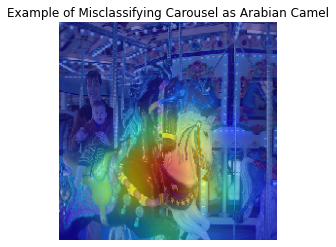

In [9]:
index = 1
heatmap = make_gradcam_heatmap(processed_img_list[index], model_ResNet50, last_conv_layer_name, pred_index=354)

return_img1 = save_and_display_gradcam(processed_img_list[index].reshape(224,224,3), heatmap, alpha =1 )
plt.title("Example of Misclassifying Carousel as Arabian Camel")
plt.axis('off')
plt.imshow(return_img1)

Text(0.5, 1.0, 'Original Image')

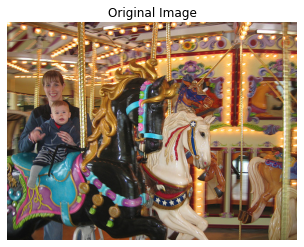

In [10]:
plt.imshow(mpimg.imread(files[index]))
plt.axis('off')
plt.title('Original Image')